#
Colab Environment



Uses TorchRL’s modern building blocks (TensorDictModule, QValueModule, EGreedyModule, DQNLoss, SoftUpdate).

Explicitly separates:

Value network (for learning with DQNLoss)

Policy wrapper (for exploration/exploitation).

This is the current recommended style in TorchRL ≥0.6 — modular, transparent, and closer to how you’d scale up to other algorithms (C51, QR-DQN, PPO, SAC, etc.).

Cleaner for customizing (e.g., adding transforms, logging, RNNs).


In [ ]:
!pip install torchrl

#!pip install torch==2.2.2
#!pip install torchrl==0.4.0 gym


In [ ]:
#To create a basic reinforcement learning agent using TorchRL
#(PyTorch's RL library), you need to set up the environment, policy, collector, and training loop. Below is a simple script for a
#DQN agent interacting with the CartPole environment using TorchRL. This illustrates essential components: environment setup,
#agent definition, data collection, and training steps.

In [ ]:
!pip -q install "torchrl>=0.6,<0.10" tensordict gymnasium


In [ ]:
import torch, torchrl, tensordict, gymnasium
print("torch:", torch.__version__)
print("torchrl:", torchrl.__version__)
print("tensordict:", tensordict.__version__)
print("gymnasium:", gymnasium.__version__)


torch: 2.8.0+cu126
torchrl: 0.9.2
tensordict: 0.9.1
gymnasium: 1.2.0


In [ ]:
import torch
from torch import nn
from tensordict.nn import TensorDictModule, TensorDictSequential
from torch.optim import Adam

from IPython.display import Markdown, display

# Silence TorchRL rounding warnings if you like
import os
os.environ["RL_WARNINGS"] = "False"


# Env
from torchrl.envs import TransformedEnv, StepCounter
try:
    # Works on recent TorchRL; fallbacks cover older packaging
    from torchrl.envs import GymEnv
except Exception:
    try:
        from torchrl.envs.libs.gym import GymEnv
    except Exception:
        from torchrl.envs.libs.gymnasium import GymEnv

env = TransformedEnv(GymEnv("CartPole-v1"), StepCounter())
env.set_seed(0)

# Value network -> QValue policy (no legacy torchrl.modules.DQN)
from torchrl.modules import MLP, QValueModule, EGreedyModule

value_mlp = MLP(out_features=env.action_spec.shape[-1], num_cells=[128])
value_net = TensorDictModule(value_mlp, in_keys=["observation"], out_keys=["action_value"])
policy = TensorDictSequential(value_net, QValueModule(spec=env.action_spec))
policy_explore = TensorDictSequential(
    policy, EGreedyModule(env.action_spec, eps_init=0.5, annealing_num_steps=10_000)
)

# Collector + replay buffer
from torchrl.collectors import SyncDataCollector
from torchrl.data import ReplayBuffer, LazyTensorStorage

collector = SyncDataCollector(
    env,
    policy_explore,
    frames_per_batch=128,
    total_frames=10_000,
    init_random_frames=1_000,
)
rb = ReplayBuffer(storage=LazyTensorStorage(100_000))

# DQN loss + optimizer + target soft-update
from torchrl.objectives import DQNLoss, SoftUpdate

loss_mod = DQNLoss(value_network=policy, action_space=env.action_spec, delay_value=True)
optim = Adam(loss_mod.parameters(), lr=1e-3)
target_updater = SoftUpdate(loss_mod, eps=0.995)

# Train
episodes = 0
for i, batch in enumerate(collector):
    rb.extend(batch)
    if len(rb) > 1_000:  # start learning after some experience
        for _ in range(10):
            sample = rb.sample(64)
            loss_vals = loss_mod(sample)
            loss_vals["loss"].backward()
            optim.step(); optim.zero_grad()
            target_updater.step()
        # anneal epsilon
        policy_explore[-1].step(batch.numel())

    episodes += batch["next", "done"].sum().item()
    if i >= 100:  # ~100 updates, similar to your loop
        break

print("Finished. Episodes seen:", episodes)


/usr/local/lib/python3.12/dist-packages/torchrl/collectors/collectors.py:870: UserWarning: total_frames (10000) is not exactly divisible by frames_per_batch (128). This means 112 additional frames will be collected.To silence this message, set the environment variable RL_WARNINGS to False.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchrl/collectors/collectors.py:887: UserWarning: init_random_frames (1000) is not exactly a multiple of frames_per_batch (128),  this results in more init_random_frames than requested (1024).To silence this message, set the environment variable RL_WARNINGS to False.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Finished. Episodes seen: 496


In [ ]:
display(Markdown(f"### ✅ Training finished!\nEpisodes seen: **{episodes}**"))

### ✅ Training finished!
Episodes seen: **496**

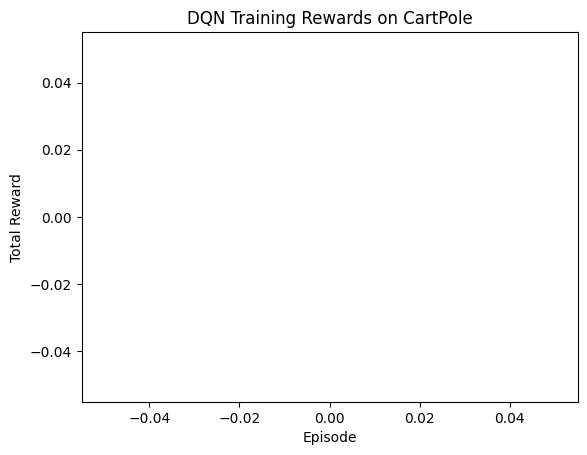

In [ ]:
import matplotlib.pyplot as plt

rewards = []
for i, batch in enumerate(collector):
    rb.extend(batch)
    if len(rb) > 1_000:
        for _ in range(10):
            sample = rb.sample(64)
            loss_vals = loss_mod(sample)
            loss_vals["loss"].backward()
            optim.step(); optim.zero_grad()
            target_updater.step()
        policy_explore[-1].step(batch.numel())

    # track episode rewards
    rewards.extend(batch["next", "reward"].sum(-2).cpu().numpy().tolist())

    if i >= 100:
        break

plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("DQN Training Rewards on CartPole")
plt.show()
